https://www.kaggle.com/datasets/msambare/fer2013

# 1. Load Dependency

## 1.1 Load Code from Github

In [1]:
#!rm -rf Data_Mining
!git clone https://github.com/VinceTruong/Data_Mining.git

Cloning into 'Data_Mining'...
remote: Enumerating objects: 45088, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 45088 (delta 6), reused 13 (delta 3), pack-reused 45070
Receiving objects: 100% (45088/45088), 63.56 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Checking out files: 100% (74698/74698), done.


## 1.2 Load necessaty tools and libraries

In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from keras.models import Sequential
from keras import regularizers
from keras.layers import AveragePooling2D, Add, Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Input, ZeroPadding2D, Activation, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = "Data_Mining/dataset/train"
test_ds = "Data_Mining/dataset/test"

# 2. Load and explore dataset

## 2.1 General Exploration

In [4]:
os.listdir(train_path) # 7 categories

['disgust', 'surprise', 'sad', 'angry', 'happy', 'fear', 'neutral']

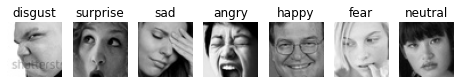

In [5]:
# explore the image and labels
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(train_path):
    img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
    
plt.show()

## 2.2 Train - Validation - Test Split

In [6]:
# The data consists of 48x48 pixel grayscale images of faces.
batch_size = 64
img_height = 48
img_width = 48

In [7]:
# Load train, validation, test from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_ds,
    labels = "inferred",
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 28522 files belonging to 7 classes.
Using 22818 files for training.
Found 28522 files belonging to 7 classes.
Using 5704 files for validation.
Found 7101 files belonging to 7 classes.


In [8]:
train_ds.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 2.3 Normalize dataset

In [9]:
train_ds_normal = train_ds.map(lambda x,y: (x/255, y))
val_ds_normal = val_ds.map(lambda x,y: (x/255, y))
test_ds_normal = test_ds.map(lambda x,y: (x/255, y))

In [10]:
#train dataset
trainX, trainY = zip(*train_ds)
trainX = np.concatenate([x for x in trainX], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
#validation dataset
valX, valY = tuple(zip(*val_ds))
valX = np.concatenate([x for x in valX], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
#test datasett
testX, testY = tuple(zip(*test_ds))
testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)

In [11]:
print(trainX.shape)
print(trainY.shape)

print(valX.shape)
print(valY.shape)

print(testX.shape)
print(testY.shape)

(22818, 48, 48, 1)
(22818, 7)
(5704, 48, 48, 1)
(5704, 7)
(7101, 48, 48, 1)
(7101, 7)


disgust


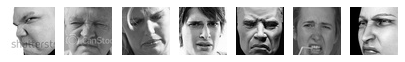

surprise


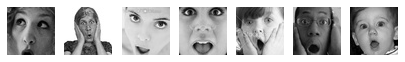

sad


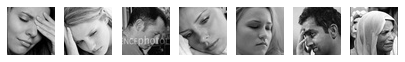

angry


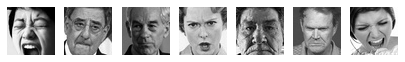

happy


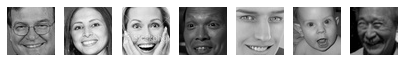

fear


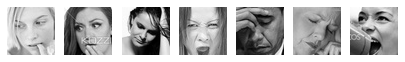

neutral


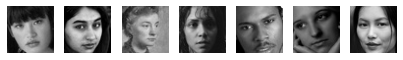

In [12]:
# Explore 7 data samples for each category
i = 1
for expression in os.listdir(train_path):
    plt.figure(figsize=(7,7))
    print(expression)
    for j in range(1, 8):
        img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[j]))
        plt.subplot(i,7,j)
        plt.imshow(img)
        plt.axis('off')
    i += 1
    plt.show()

## 2.4 Visualisation

In [13]:
train_category = list(np.sum(trainY, axis=0).astype('int64'))
print(train_category)

[3198, 340, 3267, 5784, 3899, 3831, 2499]


In [14]:
test_category = list(np.sum(testY, axis=0).astype('int64'))
print(test_category)

[944, 108, 1007, 1759, 1223, 1234, 826]


In [15]:
train_category.sort(reverse=True)
facial = ['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise','disgust']

#print(category)
dic_train = {facial[i]: train_category[i] for i in range(7)}
print(dic_train)

{'happy': 5784, 'neutral': 3899, 'sad': 3831, 'fear': 3267, 'angry': 3198, 'surprise': 2499, 'disgust': 340}


In [16]:
test_category.sort(reverse=True)

#print(category)
dic_test = {facial[i]: test_category[i] for i in range(7)}
print(dic_test)

{'happy': 1759, 'neutral': 1234, 'sad': 1223, 'fear': 1007, 'angry': 944, 'surprise': 826, 'disgust': 108}


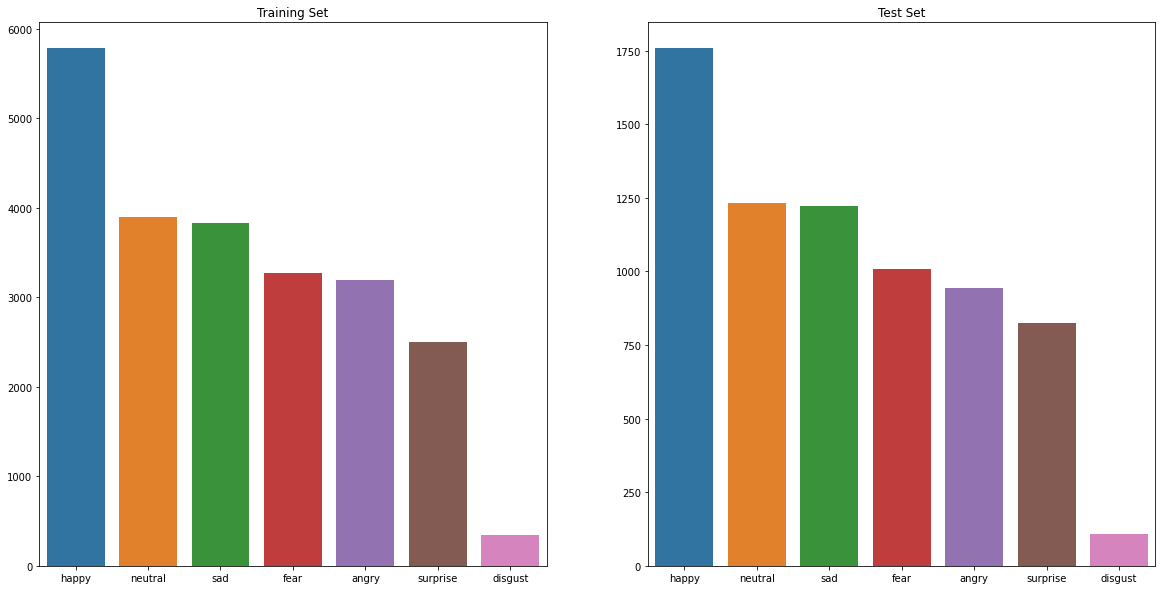

In [17]:
#Training set
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.barplot(x = list(dic_train.keys()), y = list(dic_train.values()), ax = ax[0])
ax[0].title.set_text('Training Set')
sns.barplot(x = list(dic_test.keys()), y = list(dic_test.values()), ax = ax[1])
ax[1].title.set_text('Test Set')


# 3. Model Experiment


## 3.1 Define some Plot functions

In [18]:
y_test = np.argmax(testY, axis = 1)

In [19]:
args = {
    "epochs": 20,
    "batches": 64,
    "lr": 0.0001
}
adm = Adam(learning_rate=args["lr"])

In [20]:
# roc_curve definition
def plot_multiclass_roc(y_predict, y_test):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(7):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], test_ds.class_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

#plot_multiclass_roc()

In [21]:
# confustion matrix for model result
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    sns.set(rc={'figure.figsize':(15, 15)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
labels = ['angry', 'digust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [22]:
trainY.shape

(22818, 7)

## 3.3 LeNet-5

Epoch 1/20
357/357 [==============================] - 2s 6ms/step - loss: 1.6514 - accuracy: 0.3566 - val_loss: 1.5735 - val_accuracy: 0.4034
Epoch 2/20
357/357 [==============================] - 2s 5ms/step - loss: 1.5431 - accuracy: 0.4070 - val_loss: 1.5420 - val_accuracy: 0.4130
Epoch 3/20
357/357 [==============================] - 2s 6ms/step - loss: 1.5079 - accuracy: 0.4215 - val_loss: 1.5316 - val_accuracy: 0.4176
Epoch 4/20
357/357 [==============================] - 2s 5ms/step - loss: 1.4816 - accuracy: 0.4321 - val_loss: 1.5083 - val_accuracy: 0.4251
Epoch 5/20
357/357 [==============================] - 2s 5ms/step - loss: 1.4615 - accuracy: 0.4404 - val_loss: 1.4914 - val_accuracy: 0.4281
Epoch 6/20
357/357 [==============================] - 2s 5ms/step - loss: 1.4421 - accuracy: 0.4471 - val_loss: 1.4963 - val_accuracy: 0.4236
Epoch 7/20
357/357 [==============================] - 2s 5ms/step - loss: 1.4254 - accuracy: 0.4595 - val_loss: 1.4896 - val_accuracy: 0.4311
Epoch 

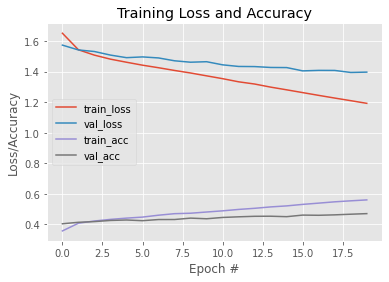

In [ ]:
#LeNet
lenet_5 =Sequential([
    Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(48,48,1), padding='same'), #C1
    AveragePooling2D(), #S2
    Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    AveragePooling2D(), #S4
    Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C5
    Flatten(), #Flatten    
    Dense(84, activation='tanh'), #F6
    Dense(7, activation='softmax')])
    
lenet_5.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
lenet_5_history = lenet_5.fit(x=trainX, y=trainY, epochs=args["epochs"], batch_size=args["batches"],validation_data=(valX, valY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), lenet_5_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), lenet_5_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), lenet_5_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), lenet_5_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [ ]:
y_predict_lenet = lenet_5.predict(testX)
y_predict_lenet_label = np.argmax(y_predict_lenet, axis = 1)

In [ ]:
accuracy_score(y_test, y_predict_lenet_label)

0.46570905506266724

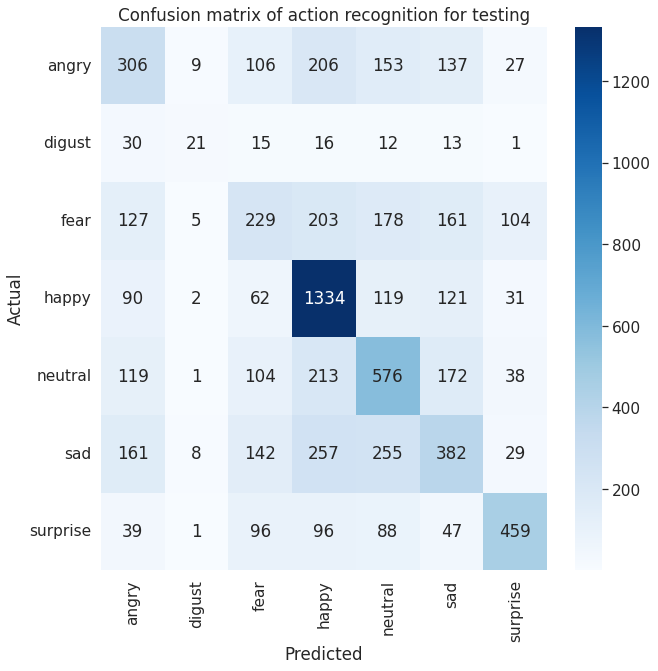

In [ ]:
plot_confusion_matrix(y_test, y_predict_lenet_label, labels = labels, ds_type =  'testing')

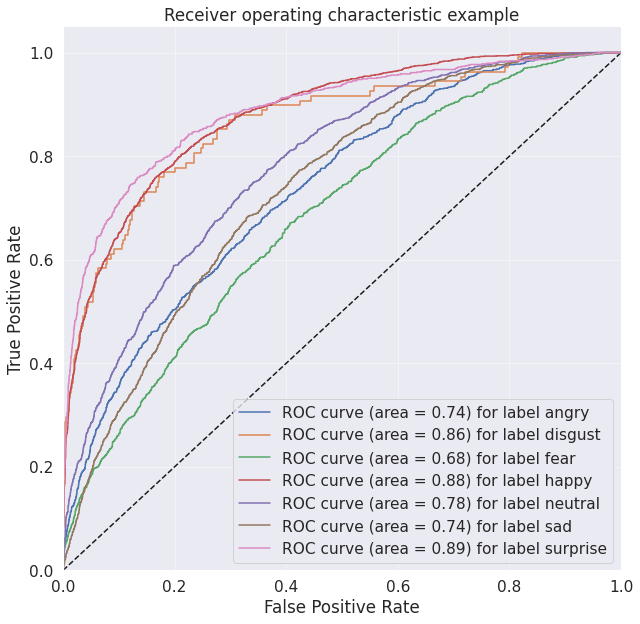

In [ ]:
plot_multiclass_roc(y_predict_lenet, testY)

## 3.2 Alex Net

Epoch 1/20
357/357 [==============================] - 32s 82ms/step - loss: 2.4945 - accuracy: 0.2710 - val_loss: 1.7128 - val_accuracy: 0.3126
Epoch 2/20
357/357 [==============================] - 28s 79ms/step - loss: 1.6343 - accuracy: 0.3552 - val_loss: 1.5423 - val_accuracy: 0.4064
Epoch 3/20
357/357 [==============================] - 29s 80ms/step - loss: 1.5157 - accuracy: 0.4112 - val_loss: 1.4943 - val_accuracy: 0.4192
Epoch 4/20
357/357 [==============================] - 29s 81ms/step - loss: 1.4342 - accuracy: 0.4436 - val_loss: 1.3917 - val_accuracy: 0.4765
Epoch 5/20
357/357 [==============================] - 29s 80ms/step - loss: 1.3685 - accuracy: 0.4681 - val_loss: 1.4520 - val_accuracy: 0.4286
Epoch 6/20
357/357 [==============================] - 28s 80ms/step - loss: 1.3089 - accuracy: 0.4959 - val_loss: 1.3225 - val_accuracy: 0.5000
Epoch 7/20
357/357 [==============================] - 29s 80ms/step - loss: 1.2657 - accuracy: 0.5095 - val_loss: 1.3121 - val_accuracy:

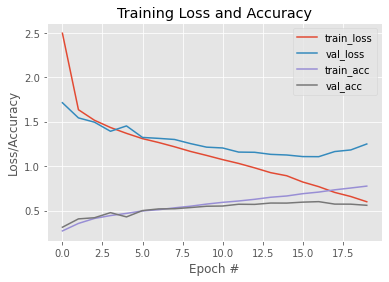

In [ ]:
#AlexNet
# Resize function to make sure code does not through an error because of negative dimensions
def process_images(image,label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 48x48 to 277x277
    image = tf.image.resize(image, (227,227))
    return image,label

train_alex = train_ds.map(process_images)
                    

val_alex =val_ds.map(process_images)
                

test_alex = test_ds.map(process_images)
               

AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Flatten())
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(7, activation='softmax'))
#AlexNet.summary()

AlexNet.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
AlexNethistory = AlexNet.fit(train_alex, epochs=args["epochs"], batch_size=args["batches"],validation_data=val_alex)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [ ]:
y_predict_alex = AlexNet.predict(test_alex)
y_predict_alex_label = np.argmax(y_predict_alex, axis = 1)

In [ ]:
accuracy_score(y_test, y_predict_alex_label)

0.16377974933108014

## 3.3 VGG16

VGG16 is convolutional neutral network introduced by K. Simonyan and A. Zisserman, who won a ILSVR(Imagenet) competition in 2014. 

Instead of using large number of hyper-parameter, it feature is using convolution layer of 3x3 filter with stride 1 and same padding, along with maxpool layer of 2x2 filter of stride 2.  

In [ ]:
# Creating model
VGG = Sequential()

# 2 x convolution layer of 64 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(input_shape=((48, 48, 1)),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 2 x convolution layer of 128 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 256 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# After several convolution layers and pooling layer, data has been flatten and loaded into fully connected layer
# 2 x Dense layers of 4096 units  +  1 x Dense Softmax layer of 7 units
VGG.add(Flatten())
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=7, activation="softmax"))

In [ ]:

adm = Adam(learning_rate=args["lr"])
VGG.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])

H = VGG.fit(x = trainX, y= trainY, validation_data=(valX, valY), epochs=args["epochs"], batch_size=args["batches"])



Epoch 1/20
357/357 [==============================] - 28s 70ms/step - loss: 1.7175 - accuracy: 0.3005 - val_loss: 1.5519 - val_accuracy: 0.3946
Epoch 2/20
357/357 [==============================] - 24s 68ms/step - loss: 1.4627 - accuracy: 0.4267 - val_loss: 1.4034 - val_accuracy: 0.4344
Epoch 3/20
357/357 [==============================] - 25s 69ms/step - loss: 1.3275 - accuracy: 0.4812 - val_loss: 1.2875 - val_accuracy: 0.5117
Epoch 4/20
357/357 [==============================] - 24s 68ms/step - loss: 1.1937 - accuracy: 0.5404 - val_loss: 1.2160 - val_accuracy: 0.5359
Epoch 5/20
357/357 [==============================] - 24s 68ms/step - loss: 1.0810 - accuracy: 0.5877 - val_loss: 1.1915 - val_accuracy: 0.5496
Epoch 6/20
357/357 [==============================] - 25s 69ms/step - loss: 0.9657 - accuracy: 0.6338 - val_loss: 1.1663 - val_accuracy: 0.5619
Epoch 7/20
357/357 [==============================] - 25s 69ms/step - loss: 0.8330 - accuracy: 0.6870 - val_loss: 1.2218 - val_accuracy:

In [ ]:
y_predict_vgg = VGG.predict(testX)
y_predict_vgg_label = np.argmax(y_predict_vgg, axis = 1)

In [ ]:
accuracy_score(y_test, y_predict_vgg_label)

0.5706238557949584

In [ ]:
print(classification_report(y_test, y_predict_vgg_label, target_names = labels))

              precision    recall  f1-score   support

       angry       0.52      0.42      0.46       944
      digust       0.86      0.40      0.54       108
        fear       0.36      0.49      0.41      1007
       happy       0.81      0.76      0.79      1759
     neutral       0.50      0.58      0.53      1223
         sad       0.46      0.39      0.42      1234
    surprise       0.75      0.71      0.73       826

    accuracy                           0.57      7101
   macro avg       0.61      0.54      0.56      7101
weighted avg       0.59      0.57      0.57      7101



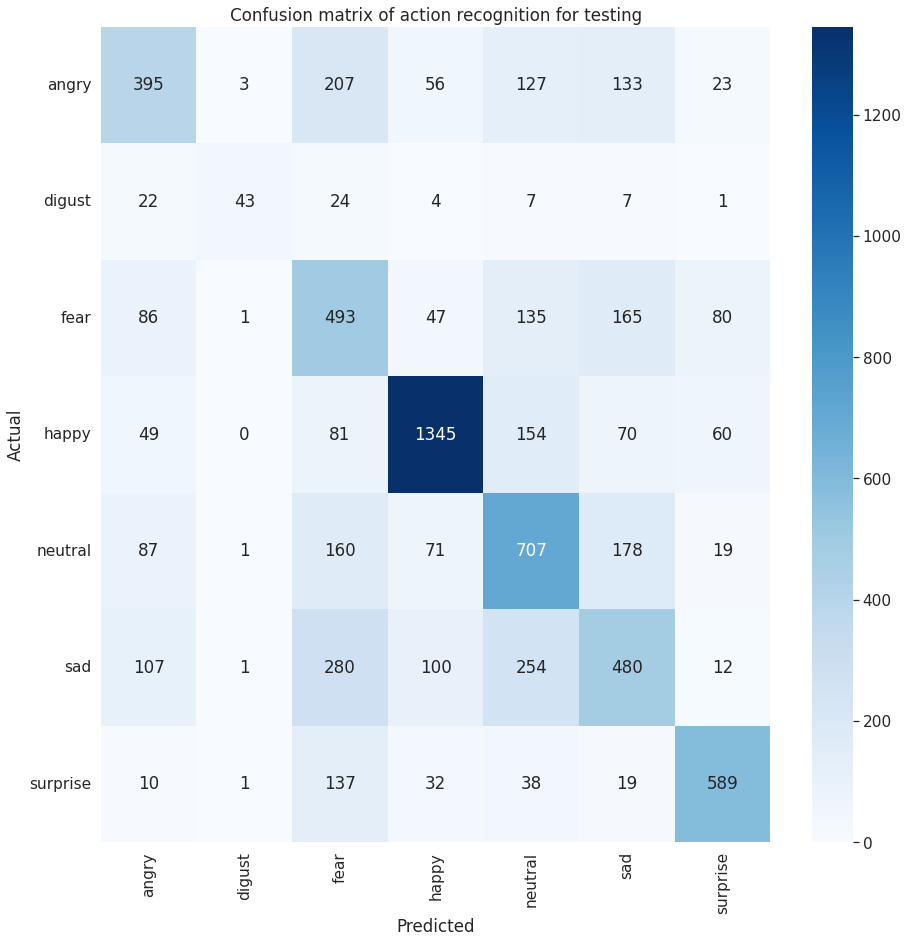

In [ ]:
plot_confusion_matrix(y_test, y_predict_vgg_label, labels, 'testing')

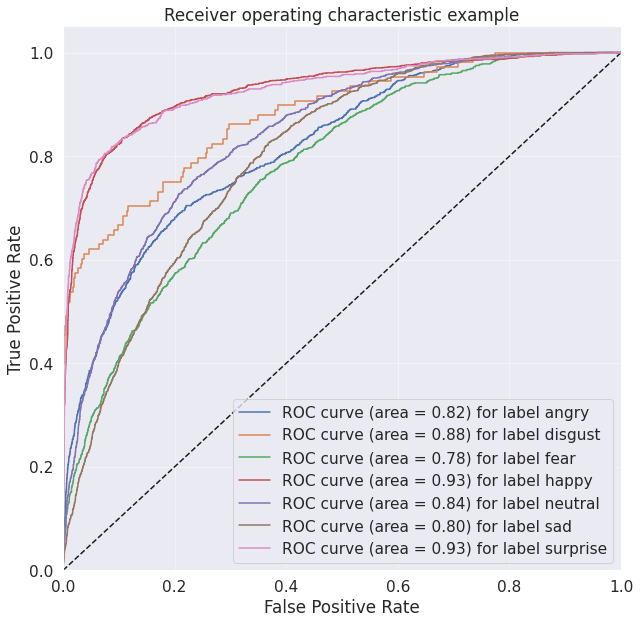

In [ ]:
plot_multiclass_roc(y_predict_vgg, testY)

## 3.4 ResNet 50

Epoch 1/10
357/357 [==============================] - 259s 677ms/step - loss: 2.1242 - accuracy: 0.2448 - val_loss: 1.8810 - val_accuracy: 0.2642
Epoch 2/10
357/357 [==============================] - 239s 669ms/step - loss: 1.8117 - accuracy: 0.3259 - val_loss: 2.1603 - val_accuracy: 0.2844
Epoch 3/10
357/357 [==============================] - 239s 669ms/step - loss: 1.6199 - accuracy: 0.3929 - val_loss: 1.6309 - val_accuracy: 0.3874
Epoch 4/10
357/357 [==============================] - 239s 669ms/step - loss: 1.4651 - accuracy: 0.4495 - val_loss: 1.5834 - val_accuracy: 0.4036
Epoch 5/10
357/357 [==============================] - 239s 668ms/step - loss: 1.3360 - accuracy: 0.5018 - val_loss: 1.4803 - val_accuracy: 0.4437
Epoch 6/10
357/357 [==============================] - 244s 682ms/step - loss: 1.2040 - accuracy: 0.5529 - val_loss: 1.5019 - val_accuracy: 0.4579
Epoch 7/10
357/357 [==============================] - 239s 669ms/step - loss: 1.0666 - accuracy: 0.6090 - val_loss: 1.6823 -

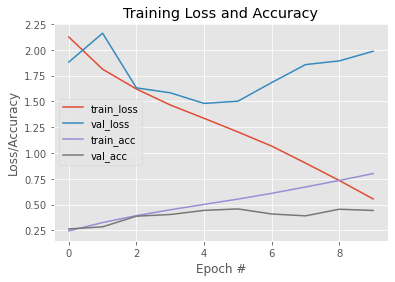

In [23]:
# ResNet50
def process_images(image,label):
    # Resize images from 48x48 to 224x224
    image = tf.image.resize(image, (224,224))
    return image,label

train_res = (train_ds.map(process_images))
val_res = (val_ds.map(process_images))
test_res = (test_ds.map(process_images))

def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)
  
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape, classes):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

input_shape = (224, 224, 1)
n_classes = 7
ResNet50 = ResNet50(input_shape, n_classes)
#ResNet50.summary()

args = {
    'batches' : 256,
    'epochs' : 10,
    'learning_rate' : 0.0001
}


optimizer = Adam (learning_rate = 0.0001)
ResNet50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_history = ResNet50.fit(train_res, epochs=args["epochs"], batch_size=args['batches'],validation_data=val_res)  

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), ResNet50_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), ResNet50_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), ResNet50_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), ResNet50_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [24]:
y_predict_resnet = ResNet50.predict(test_res)
y_predict_resnet_label = np.argmax(y_predict_resnet, axis = 1)

222/222 [==============================] - 23s 95ms/step


In [27]:
accuracy_score(y_test, y_predict_resnet_label)

0.16546965216166737

# 4. Conclusion

After training two models, we can infer that:
- AlexNet, ResNet Model: high accuracy on training and validation set, but low accuracy, F1 score on test set (as shown in classification report, ROC curve and confusion matrix)
- LeNet-5: The score is better than the two previous model but still underfittin
- VGG16 Model: though performing very well on training set (0.99 accurracy), it is overfitting on validation set (the more epoches, the more loss value is). However, its performance on test set is acceptable since F1 score and accuracy are higher than that of other two models.  